# Current Best Practice to Upload and Graph .nc Files
## By Syd Levy

In [1]:
#install packages
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colorbar, colors
from matplotlib.cm import get_cmap
from matplotlib.patches import Rectangle
import seawater
import glob

# Step 1: Lazy load the data

First indicate the desired variables, designated as variable_1 and variable_2. In this case, it is Alk and Dissolved Inorganic Carbon (DIC).
Create the preprocess function. This function is used in the xr.open_mfdataset function, and ensures that only the designated variables will be processed.
Call the xarray function open_mfdataset. Insert desired methods for combine and concat_dim arguments. Most importantly, "call chunks={}" and "parallel=True" to enable lazy loading and parallel processing.


In [5]:
%%time
variable_1 = 'Alk'
variable_2 =  'DIC'
def preprocess(ds): #isolate Alk and DIC
    return ds[[variable_1,variable_2]]
x = xr.open_mfdataset( # load data
    "/expanse/lustre/projects/cos100/slevy1/icelandBGCdata/*.nc", #path to file folder
    combine='nested', # combination instruction
    concat_dim=["time"], #concatination instruction
    preprocess=preprocess, #isolate DIC and Alk variables by invoking the preprocess function
    chunks={}, #allow vars
    parallel=True #induce paralell processing
)



CPU times: user 1.35 s, sys: 1.02 s, total: 2.37 s
Wall time: 1.77 s


In [6]:
print(x.data_vars) #verify our data set has the correct variables.

Data variables:
    Alk      (time, depth, eta_rho, xi_rho) float32 81GB dask.array<chunksize=(24, 40, 722, 722), meta=np.ndarray>
    DIC      (time, depth, eta_rho, xi_rho) float32 81GB dask.array<chunksize=(24, 40, 722, 722), meta=np.ndarray>


# Step 2: Isolate the necessary data for the line graphs

We want to create Alkalinity and DIC graphs as a function of time for a specific area of the fjord. We are going to further pare down our lazy loaded data set to only include the data that we which to plot by removing land values, specifiying the specific geographic location, and then calculating the average Alkalinity and DIC as a function of depth.

**Only after we have calculated the exact data we want to visualize do we tell it to load.**


In [7]:
%%time
dslice = x.where(x['Alk'] != 0) #remove land values
dslice = dslice.sel(eta_rho=slice(502,522), xi_rho=slice(595,610)).mean(dim=('time', 'xi_rho', 'eta_rho')) #isolate specific geographic location
dslice = dslice.load() #load data into memory for plotting

CPU times: user 2min 5s, sys: 3min 29s, total: 5min 35s
Wall time: 4min 33s


# Step 3: Plot the line graphs

That plots should appear near instantaneously, as we have already loaded the exact data we are plotting.

CPU times: user 16.8 ms, sys: 5.4 ms, total: 22.2 ms
Wall time: 23.6 ms


<function matplotlib.pyplot.show(close=None, block=None)>

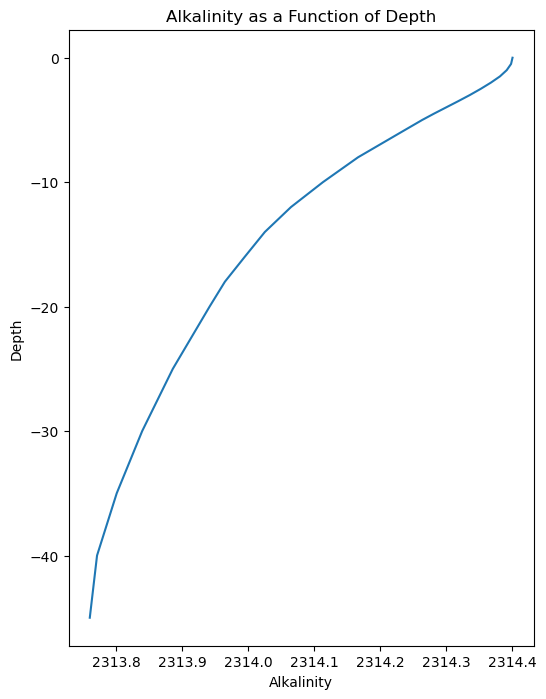

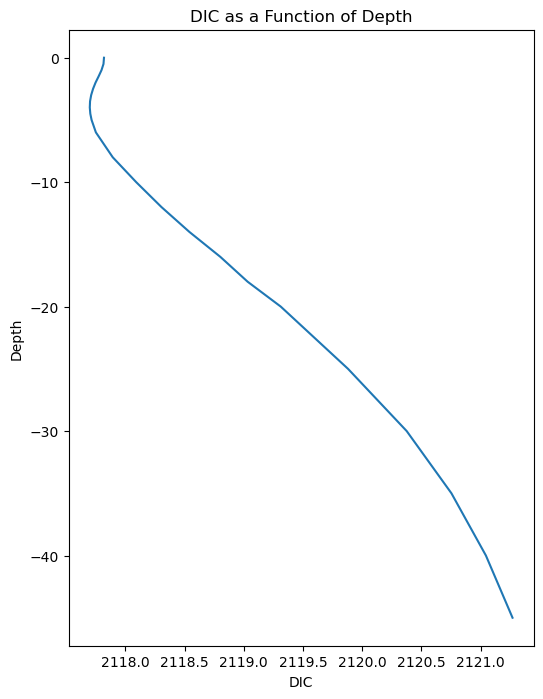

In [8]:
%%time

alkalinity = dslice['Alk'] #isolate 'Alk' values
depth = dslice['depth'] #isolate 'depth' values
DIC = dslice['DIC'] #isolate 'DIC' values

# Create a plot of alkalinity vs. depth
plt.figure(figsize=(6, 8))
plt.plot(alkalinity, depth)
plt.xlabel('Alkalinity')
plt.ylabel('Depth')
plt.title('Alkalinity as a Function of Depth')
plt.show

# Create a plot of alkalinity vs. depth
plt.figure(figsize=(6, 8))
plt.plot(DIC, depth)
plt.xlabel('DIC')
plt.ylabel('Depth')
plt.title('DIC as a Function of Depth')
plt.show

# Step 4: Isolate data for surface plots

Similar to "Step 2", we isolate the data we need to create the surface plots, **and we only load it once we have completely isolated and calculated the exact data we want to plot**.

In [9]:
%%time
top = x.sel(depth=0).mean(dim='time') #select only surface data
top = top.where(top['Alk'] != 0) #remove land values
top = top.load()  #load for plotting


CPU times: user 3.79 s, sys: 1min 49s, total: 1min 53s
Wall time: 2min 1s


# Step 5: Plot the surface plots and boxplots

The surface plots include a rectangle that designates what area was being plotted in the line plots above.
The box plots require that the data arrays be flattened to a single dimension and that the land values be removed.

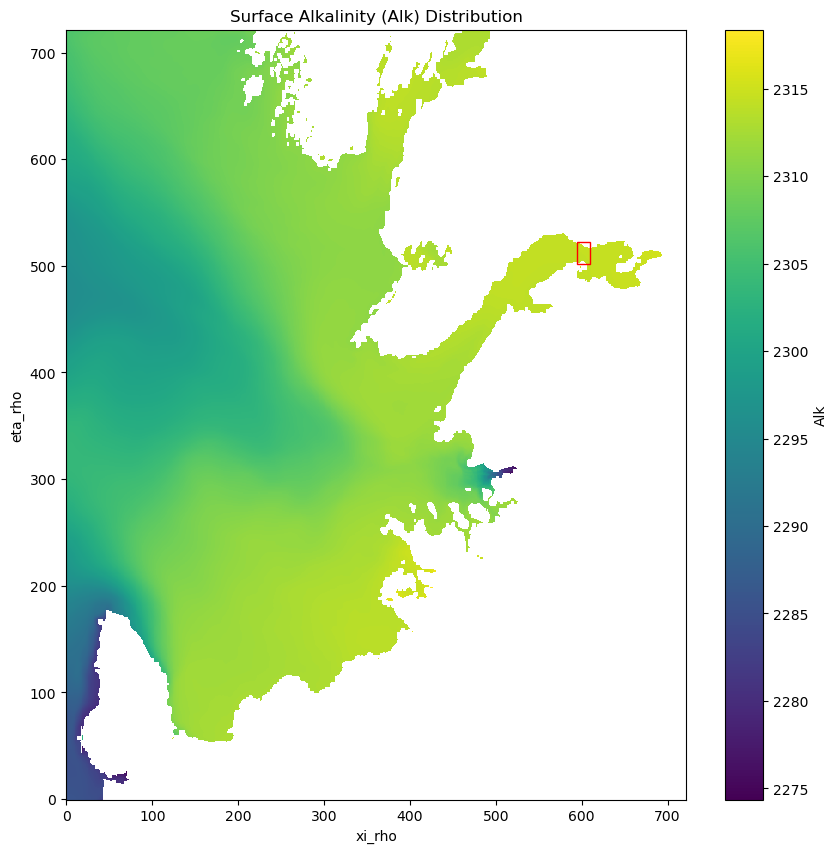

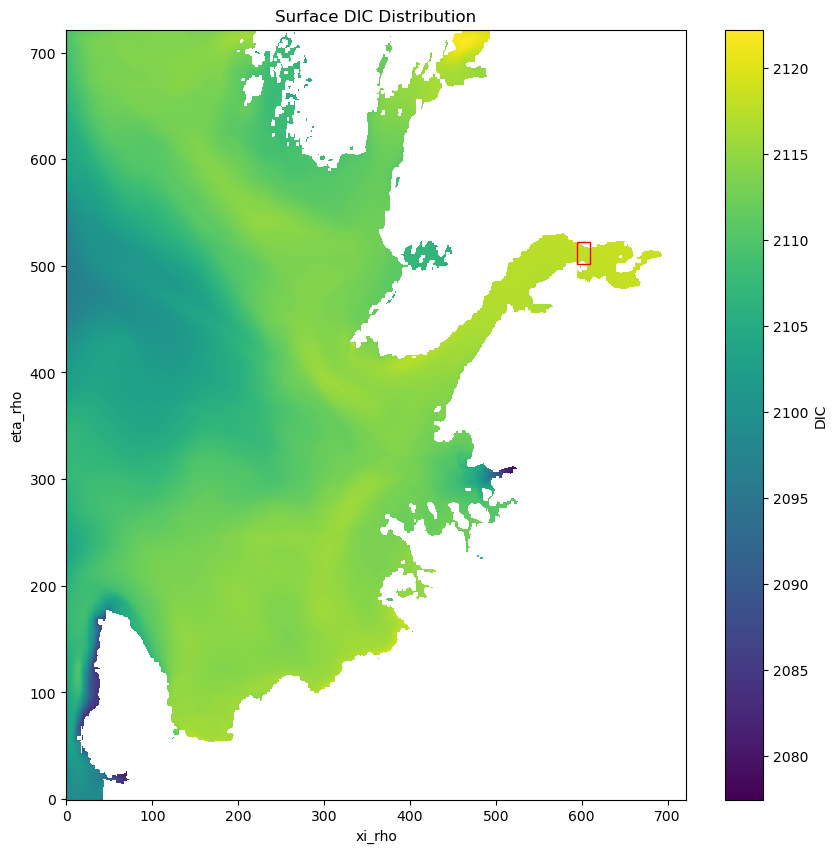

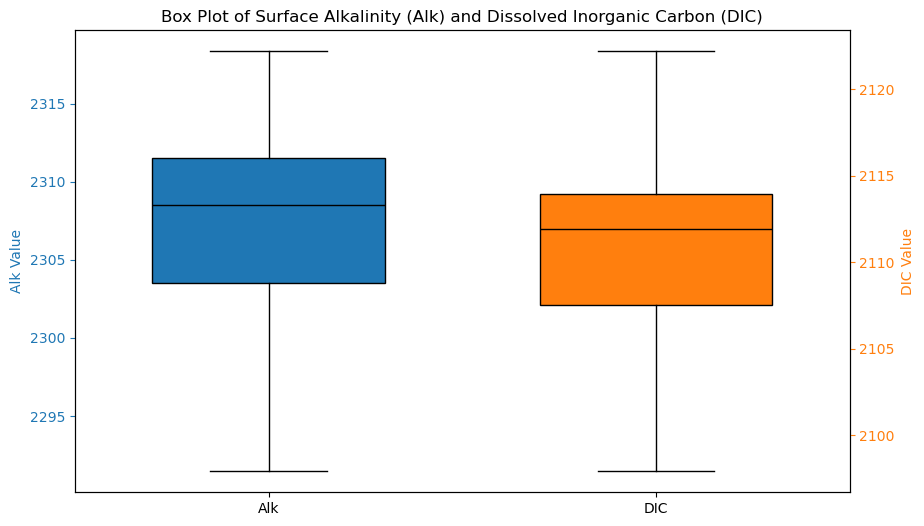

CPU times: user 968 ms, sys: 29.1 ms, total: 997 ms
Wall time: 999 ms


In [10]:
%%time

alk_surface = top['Alk'] #isolate 'Alk' values for surface
dic_surface = top['DIC'] #isolate 'DIC' values for surface

rectangle_alk = Rectangle((595, 502), 15, 20, linewidth=1, edgecolor='r', facecolor='none') #rectangle showing plotted area on Alk 

# Create the 'Alk' plot
plt.figure(figsize=(10, 10))
alk_surface.plot(x='xi_rho', y='eta_rho')
plt.title('Surface Alkalinity (Alk) Distribution')
plt.xlabel('xi_rho')
plt.ylabel('eta_rho')
plt.gca().add_patch(rectangle_alk)
plt.show()

rectangle_dic = Rectangle((595, 502), 15, 20, linewidth=1, edgecolor='r', facecolor='none')

# Create the 'DIC plot
plt.figure(figsize=(10, 10))
dic_surface.plot(x='xi_rho', y='eta_rho')
plt.title('Surface DIC Distribution')
plt.xlabel('xi_rho')
plt.ylabel('eta_rho')
plt.gca().add_patch(rectangle_dic)
plt.show()

#Reformat Data for Box Plot & remove land values
alk_flat = alk_surface.values.flatten()
alk_flat_clean = alk_flat[~np.isnan(alk_flat)]
dic_flat = dic_surface.values.flatten()
dic_flat_clean = dic_flat[~np.isnan(dic_flat)]


#rename data for plotting
data_to_plot_1 = alk_flat_clean  # Data for the first plot
data_to_plot_2 = dic_flat_clean  # Data for the second plot

#create boxplot
fig, ax1 = plt.subplots(figsize=(10, 6))
bp1 = ax1.boxplot(data_to_plot_1, positions=[1], widths=0.6, labels=['Alk'], patch_artist=True, boxprops=dict(facecolor="C0"), showfliers=False)
ax2 = ax1.twinx()
bp2 = ax2.boxplot(data_to_plot_2, positions=[2], widths=0.6, labels=['DIC'], patch_artist=True, boxprops=dict(facecolor="C1"), showfliers=False)
ax1.set_ylabel('Alk Value', color='C0')
ax2.set_ylabel('DIC Value', color='C1')
ax1.tick_params(axis='y', colors='C0')
ax2.tick_params(axis='y', colors='C1')
for median in bp1['medians']:
    median.set_color('black')
for median in bp2['medians']:
    median.set_color('black')
plt.title('Box Plot of Surface Alkalinity (Alk) and Dissolved Inorganic Carbon (DIC)')
plt.show()

# Conclusion

This method is nearly twice as fast as the next fastest loading, concatenating, and plotting method I tested. The speed comes from a combination of utilizing the lazy loading, concatenating, and paralell processing, aspects of the open_mfdataset function, and explicitly loading only the exact data we want desire to plot prior to actually plotting the data.

I am curious as to why .load() of the plotting data prior to the actual plotting function increases speed. I would think that the plot function, when called, would only load the data needed to plot, making a .load() of the data unnecessary. Yet, it does make a difference in the speed of the process.

### Other considerations:
1) chunks={} "chunks" the data by dimension. Is it possible to "chunk" it by variable? If is, this might significantly decrease the time needed to pare down data, as entire may be able to be ignored at once. I am not sure if this is true, but it could be worth trying.
2) There might be further optimizations around the order of calculations. For example, in Step 2, it might be most optimal to select the exact area of data we want to analyze, then filter out the land values, then calculate the data. This might not make a significant difference if the calculation times are small compared to the loading times of the data. 
3) Step 5, we flatten the data arrays we have already loaded to create the boxplots. I believe that this is the fastest way to do this, as we already have to load the data to create the surface plots, but it does go against the general philosophy of calculate exactly what you want to plot, and then load.

 